# Single Type Experiment

In [119]:
import warnings;
warnings.filterwarnings('ignore');

from time import sleep
from tqdm.auto import tqdm

import sys
import importlib
import numpy as np
import nbformat
import pandas as pd
import scipy.optimize as optimization
import matplotlib.pyplot as plt
import seaborn as sns

### Confidence Radius

In [120]:
cthresh = 1
cup = 1
clow = 1
Linf = 1/3

### Offline Optimal Solution

In [121]:
def offline_opt(budget, size, mean):
    # return [budget / np.sum(size) * size[i] for i in range(len(size))]
    return [budget / np.sum(size) for i in range(len(size))]

### Threshold Based Algorithms

In [79]:
def fixed_threshold(budget, size, mean):
    allocation = np.zeros(len(size))
    budget_remaining = budget
    
    rem = len(size)
    size_future = size[0] + np.sum(mean[1:])
    
    thresh = (budget / size_future) - (cthresh / (rem**(1/2)))
    # thresh = budget / (size[0] + np.sum(mean[1:]) + clow*np.sqrt(np.log(len(size)-1) * (len(size)-1)))
    
    
    for i in range(len(allocation)):
        # allocation[i] = min(budget_remaining, thresh * size[i])
        allocation[i] = min(budget_remaining / size[i], thresh)
        budget_remaining -= allocation[i] * size[i]
    return allocation

In [5]:
# def sid_threshold(budget, size, mean):
#     allocation = np.zeros(len(size))
#     budget_remaining = budget

#     conf_bnd = (np.sum(mean[1:]))**(0.6) #c*np.sqrt(np.sum(mean)* np.log(len(size)-1)) 

#     # thresh_lower = budget / (size[0] + np.sum(mean[1:]) + clow*conf_bnd)
#     #thresh_upper = budget / (size[0] + np.sum(mean[1:]) - cup*conf_bnd)

#     rem = len(size)
    
#     thresh_lower = budget / (size[0] + np.sum(mean[1:])) - (cthresh * rem**Linf)
#     thresh_upper = budget / (size[0] + np.sum(mean[1:])) + (cthresh * rem**Linf)
    
#     for i in range(len(allocation)-1):
#         # TODO: add on confidence terms for (T - i) people here
#         #rem = len(allocation) - (i + 1)
#         budget_upper = thresh_upper*(size[i] + np.sum(mean[i+1:])) # + c*np.sqrt(rem * np.log(rem)))
#         budget_lower = thresh_lower*(size[i] + np.sum(mean[i+1:])) # + c*np.sqrt(rem * np.log(rem)))

#         gam = (budget_remaining - budget_lower) / (budget_upper - budget_lower)
        
#         if gam >= 0.95: allocation[i] = thresh_upper
#         else: allocation[i] = thresh_lower
        
#         if allocation[i] * size[i] <= budget_remaining:
#             budget_remaining -= allocation[i] * size[i]
#         else:
#             allocation[i] = budget_remaining/size[i]
#             print('Sid: Running Out of Budget!')
#             budget_remaining = 0

#         if budget_remaining < 0:
#             print("Error: Negative Budget")

            
#     # fix for last agent
#     allocation[-1] = min(thresh_upper, budget_remaining / size[-1])
    
#     return allocation





def sid_threshold(budget, size, mean):
    allocation = np.zeros(len(size))
    budget_remaining = budget
    
    rem = len(size)
    thresh_lower = budget / (size[0] + np.sum(mean[1:])) - (cthresh / (rem**Linf))
    thresh_upper = budget / (size[0] + np.sum(mean[1:])) + (cthresh / (rem**Linf))
    
    for i in range(len(allocation)):
        # TODO: add on confidence terms for (T - i) people here
        #rem = len(allocation) - (i + 1)
        budget_upper = thresh_upper*(size[i] + np.sum(mean[i+1:]))
        budget_lower = thresh_lower*(size[i] + np.sum(mean[i+1:]))

        theta = (cthresh / (rem ** Linf)) * ((1/2) * np.sum(mean[i+1:])+ size[i])
        
        if budget_remaining >= budget_lower + theta:
            allocation[i] = min(budget_remaining / size[i], thresh_upper)
        else:
            allocation[i] = min(budget_remaining / size[i], thresh_lower)
            
        budget_remaining -= size[i] * allocation[i]
        
#         if budget_remaining <= 0:
#             print("Sid: Out of Budget")

    return allocation




In [100]:
def hope_guardrail_13(budget, size, mean):
    allocation = np.zeros(len(size))
    budget_remaining = budget
    
    


    
    rem = len(size)
#     thresh_lower = max(0, budget / (size[0] + np.sum(mean[1:])) - (cthresh / (rem**Linf)))

    size_future = size[0] + np.sum(mean[1:])
    
    thresh_lower = (budget / size_future)*(1 - (np.sqrt(cthresh*rem*np.log(rem)) / size_future) - (cthresh*np.log(rem) / size_future))
    
    thresh_upper = thresh_lower + (cthresh / (rem**Linf))
    
    if thresh_lower < 0:
        print('Rem: ' + str(rem))
        print('Denom of L_T: ' + str(rem ** Linf))
        print('Expect Allocation: ' + str(budget / (size[0] + np.sum(mean[1:]))))
        print((cthresh / (rem**Linf)))
        print('ERRRORRRRRR!')
    
    
    for i in range(len(allocation)):
    
        rem = len(allocation) - i
        conf_bnd = np.sqrt(np.mean(mean)*(rem))
        
        
        if budget_remaining / size[i] < thresh_lower:
            # print(str(i) + ' giving rest of budget!')
            allocation[i] = budget_remaining / size[i]
        
        
        
        elif budget_remaining >= thresh_lower * (np.sum(mean[i+1:]) + clow*conf_bnd) + size[i] * thresh_upper:
            allocation[i] = thresh_upper

        else:
            allocation[i] = thresh_lower

            
        budget_remaining -= allocation[i] * size[i]

        
    if np.round(budget_remaining, 3) < 0:
        print(budget_remaining)
        print('Error: Negative Budget')
                
        
    return allocation



In [7]:
def adapt_init_under_over_threshold(budget, size, mean):
    
    
    
    allocation = np.zeros(len(size))
    budget_remaining = budget
    
    

    rem = len(size)
    size_future = size[0] + np.sum(mean[1:])
    
    thresh_lower = (budget / size_future)*(1 - (np.sqrt(cthresh*rem*np.log(rem)) / size_future) - (cthresh*np.log(rem) / size_future))

    thresh_upper = budget / (size[0] + np.sum(mean[1:])) + (cthresh / np.sqrt(len(size)*np.log(len(size))))
    
    for i in range(len(allocation)):
    
        rem = len(allocation) - i
        conf_bnd = np.sqrt(np.mean(mean)*(rem* np.log(rem)))     
        
        
        if budget_remaining / size[i] < thresh_lower:
            # print(str(i) + ' giving rest of budget!')
            allocation[i] = budget_remaining / size[i]
        
        elif budget_remaining <= thresh_upper * (np.sum(mean[i+1:]) + clow*conf_bnd) + size[i] * thresh_lower:
            allocation[i] = thresh_lower

        else:
            allocation[i] = min(budget_remaining / size[i], thresh_upper)

            
        budget_remaining -= allocation[i] * size[i]

        
    if np.round(budget_remaining, 3) < 0:
        print(budget_remaining)
        print('Error: Negative Budget')
                
        
    return allocation

In [8]:
def adapt_threshold(budget, size, mean):
    allocation = np.zeros(len(size))
    budget_remaining = budget
    
    
    


    rem = len(allocation)
    conf_bnd = np.sqrt(np.mean(mean)*(rem* np.log(rem))) 


    # print(thresh_lower, thresh_upper)
    
    for i in range(len(allocation)):
    
    
        rem = len(allocation) - i
        conf_bnd = np.sqrt(np.mean(mean)*(rem* np.log(rem))) 
        # calculates initial thresholds
#         thresh_lower = budget / (np.sum(size[0:i+1]) + np.sum(mean[i+1:]) + clow*conf_bnd)
#         thresh_upper = budget / (np.sum(size[0:i+1]) + np.sum(mean[i+1:]) - cup*conf_bnd)      
        thresh_lower = budget / (size[0] + np.sum(mean[1:])) - (cthresh * rem**Linf)
        thresh_upper = budget / (size[0] + np.sum(mean[1:])) + (cthresh * rem**Linf)

        
        if budget_remaining / size[i] < thresh_lower:
            # print(str(i) + ' giving rest of budget!')
            allocation[i] = budget_remaining / size[i]
        
        elif budget_remaining >= thresh_lower * (np.sum(mean[i+1:]) + clow*conf_bnd) + size[i] * thresh_upper:
            allocation[i] = thresh_upper

        else:
            allocation[i] = thresh_lower

            
        budget_remaining -= allocation[i] * size[i]

        
    if np.round(budget_remaining, 3) < 0:
        print(budget_remaining)
        print('Error: Negative Budget')
                
        
    return allocation

In [9]:
def adapt_init_threshold_new_cb(budget, size, mean):
    allocation = np.zeros(len(size))
    budget_remaining = budget
    
    
    

    rem = len(allocation)
    conf_bnd = np.sqrt(np.mean(mean)*(rem* np.log(rem))) 

    # calculates initial thresholds
#     thresh_lower = budget / (np.sum(size[0]) + np.sum(mean[1:]) + clow*conf_bnd)
#     thresh_upper = budget / (np.sum(size[0]) + np.sum(mean[1:]) - cup*conf_bnd)  
    # print(thresh_lower, thresh_upper)
    
    thresh_lower = budget / (size[0] + np.sum(mean[1:])) - (cthresh / np.sqrt(len(size)*np.log(len(size))))
    thresh_upper = budget / (size[0] + np.sum(mean[1:])) + (cthresh / np.sqrt(len(size)*np.log(len(size))))
    
    for i in range(len(allocation)):   
        
        
        if budget_remaining / size[i] < thresh_lower:
            # print(str(i) + ' giving rest of budget!')
            allocation[i] = budget_remaining / size[i]
        elif budget_remaining >= thresh_upper * (size[0] + np.sum(mean[1:]) + np.sum(size[0:i+1]) - clow*conf_bnd) + size[i] * thresh_upper:
            allocation[i] = thresh_upper

        else:
            allocation[i] = thresh_lower

            
        budget_remaining -= allocation[i] * size[i]

        
    if np.round(budget_remaining, 3) < 0:
        print(budget_remaining)
        print('Error: Negative Budget')
                
        
    return allocation



In [10]:
def epoch_threshold(budget, size, mean):
    allocation = np.zeros(len(size))
    budget_remaining = budget
    
     
    epoch_length = int(np.ceil(1 / (len(size)**(2*Linf))))
    num_epochs = len(size) / epoch_length
    
    print('Num Epochs: ' + str(num_epochs))
    print('Epoch Length: ' + str(epoch_length))
    
    index = 0
    for k in range(int(np.floor(num_epochs))):
        epoch_budget = budget_remaining / (num_epochs)
        lower_thresh = max(0, epoch_budget / (size[index] + np.sum(mean[index+1:index+epoch_length+1])) - (cthresh * epoch_length**Linf))
        for _ in range(epoch_length):
            allocation[index] = min(budget_remaining / size[index], lower_thresh)
            budget_remaining -= size[index] * allocation[index]
            index += 1
            
    if index != len(size):
        print('Carry over due to rounding: ' + str(index))
        epoch_budget = budget_remaining
        lower_thresh = epoch_budget / (size[index] + np.sum(mean[index+1:len(size)])) - (cthresh * epoch_length**Linf)
        for _ in range(len(size) - index):
            allocation[index] = min(budget_remaining / size[index], lower_thresh)
            budget_remaining -= size[index]*allocation[index]
            index += 1
        
    return allocation

### Online EG-Based Methods

In [11]:
def hope_online(budget, size, mean):
    # initialize allocation vector
    allocation = np.zeros(len(size))
    budget_remaining = budget
    for i in range(len(allocation)):
        # allocation[i] = budget_remaining * size[i] / (size[i] + np.sum(mean[i+1:]))
        allocation[i] = budget_remaining / (size[i] + np.sum(mean[i+1:]))
        
        
        budget_remaining -= allocation[i] * size[i]
    return allocation

In [12]:
def hope_full(budget, size, mean):
    allocation = np.zeros(len(size))
    budget_remaining = budget
    for i in range(len(allocation)):
#         allocation[i] = min(budget_remaining, budget*size[i] / (np.sum(size[0:i+1]) + np.sum(mean[i+1:])))
        allocation[i] = min(budget_remaining / size[i], budget / (np.sum(size[0:i+1]) + np.sum(mean[i+1:])))

        budget_remaining -= allocation[i] * size[i]
    return allocation



### Test

In [13]:
n = 6
sorted_distribution = np.asarray([np.arange(2) + 1 for x in range(n)])
weights = np.asarray([np.zeros(2)+0.5 for x in range(n)])
mean = [np.dot(weights[i], sorted_distribution[i]) for i in range(n)]

expected_demand = 1.5
budget = n * expected_demand
print(budget)

9.0


In [14]:
print(weights)

[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]


In [15]:
print(sorted_distribution)

[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]]


In [16]:
size = [2., 1., 1., 1., 2., 1.]

In [17]:
algo_list = [offline_opt, hope_online, hope_full, adapt_threshold, adapt_init_threshold, sid_threshold, fixed_threshold, epoch_threshold]

In [18]:
for algo in algo_list:
    print(algo.__name__)
    print(algo(budget, size, mean))

offline_opt
[1.125, 1.125, 1.125, 1.125, 1.125, 1.125]
hope_online
[0.94736842 1.01503759 1.10731374 1.24572796 1.06776682 1.60165023]
hope_full
[0.94736842 1.         1.05882353 1.125      1.05882353 1.125     ]
adapt_threshold
[ 3.39685816  3.1834364   2.94736842 -3.92452115 -0.46684514 -0.05263158]
adapt_init_threshold
[1.35561671 1.35561671 0.53912013 1.35561671 0.53912013 0.53912013]
sid_threshold
[1.35561671 1.35561671 1.35561671 1.35561671 0.53912013 1.14367618]
fixed_threshold
[0.53912013 0.53912013 0.53912013 0.53912013 0.53912013 0.53912013]
epoch_threshold
Num Epochs: 6.0
Epoch Length: 1
[0.  0.  0.  0.  0.  0.5]


### Scaling with n

In [19]:
#np.random.choice(size=5, a=[1.,2.], p=[1/2, 1/2])
1+np.random.poisson(size=5,lam = 1.5)

array([2, 3, 2, 5, 2])

In [116]:
data = []

# algo_list = [adapt_init_threshold, hope_full, hope_online, fixed_threshold]

# algo_list = [fixed_threshold, adapt_init_threshold, sid_threshold, epoch_threshold]

algo_list = [fixed_threshold, adapt_init_threshold]

num_iterations = 100
max_n = 10000

mean_size = 1.5

# for n in tqdm(np.arange(1, max_n+1, 1000)):

num_groups = np.logspace(2, 20, base=1.5, num=100).astype(int)

for n in tqdm(num_groups):
    n = int(n) + 5
    expected_size = np.zeros(n) + mean_size
    budget = n
    
    for i in range(num_iterations):
        size = np.random.choice(size=n, a=[1.,2.], p=[1/2, 1/2])
        # size = 1+np.random.poisson(size=n,lam = mean_size-1)
        
        opt = offline_opt(budget, size, expected_size)
        
        for algo in algo_list:
            sol = algo(budget, size, expected_size)
            
            data_dict = {'NumGroups': n, 'Algorithm':algo.__name__, 'Norm': 'L1', 'Value': np.sum(np.abs(opt-sol))}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm':algo.__name__, 'Norm': 'Linf', 'Value': np.max(np.abs(opt-sol))}
            data.append(data_dict)
            
            if np.dot(size, sol) > budget:
                print('ERROR: ' + str(algo.__name__))
                print(np.dot(size, sol), budget)
            
            data_dict = {'NumGroups': n, 'Algorithm':algo.__name__, 'Norm': 'Waste', 'Value': (budget - np.dot(size, sol))}
            data.append(data_dict)
        
    sleep(0)

  0%|          | 0/100 [00:00<?, ?it/s]

ERROR: adapt_init_threshold
20.000000000000004 20
ERROR: adapt_init_threshold
20.000000000000004 20
ERROR: adapt_init_threshold
22.000000000000014 22
ERROR: adapt_init_threshold
22.000000000000018 22
ERROR: adapt_init_threshold
32.00000000000001 32
ERROR: adapt_init_threshold
36.00000000000001 36
ERROR: adapt_init_threshold
44.00000000000001 44
ERROR: adapt_init_threshold
47.00000000000004 47
ERROR: adapt_init_threshold
51.00000000000005 51
ERROR: adapt_init_threshold
51.00000000000001 51
ERROR: adapt_init_threshold
67.00000000000004 67
ERROR: adapt_init_threshold
67.00000000000004 67
ERROR: adapt_init_threshold
71.00000000000001 71
ERROR: adapt_init_threshold
76.00000000000007 76
ERROR: adapt_init_threshold
76.00000000000003 76
ERROR: adapt_init_threshold
76.00000000000003 76
ERROR: adapt_init_threshold
88.00000000000003 88
ERROR: adapt_init_threshold
88.00000000000004 88
ERROR: adapt_init_threshold
94.00000000000006 94
ERROR: adapt_init_threshold
94.00000000000011 94
ERROR: adapt_ini

ERROR: adapt_init_threshold
2141.0000000000286 2141
ERROR: adapt_init_threshold
2141.0000000000578 2141
ERROR: adapt_init_threshold
2141.0000000000286 2141
ERROR: adapt_init_threshold
2141.000000000061 2141
ERROR: adapt_init_threshold
2305.0000000000227 2305
ERROR: adapt_init_threshold
2305.000000000031 2305
ERROR: adapt_init_threshold
2305.0000000000296 2305
ERROR: adapt_init_threshold
2305.000000000029 2305
ERROR: adapt_init_threshold
2481.0000000000064 2481
ERROR: adapt_init_threshold
2481.0000000000136 2481
ERROR: adapt_init_threshold
2481.0000000000414 2481
ERROR: adapt_init_threshold
2481.0000000000387 2481
ERROR: adapt_init_threshold
2481.0000000000155 2481
ERROR: adapt_init_threshold
2481.0000000000355 2481
ERROR: adapt_init_threshold
2481.000000000039 2481
ERROR: adapt_init_threshold
2481.000000000003 2481
ERROR: adapt_init_threshold
2481.000000000001 2481
ERROR: adapt_init_threshold
2481.0000000000255 2481
ERROR: adapt_init_threshold
2481.0000000000437 2481
ERROR: adapt_init_

/home/sean/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


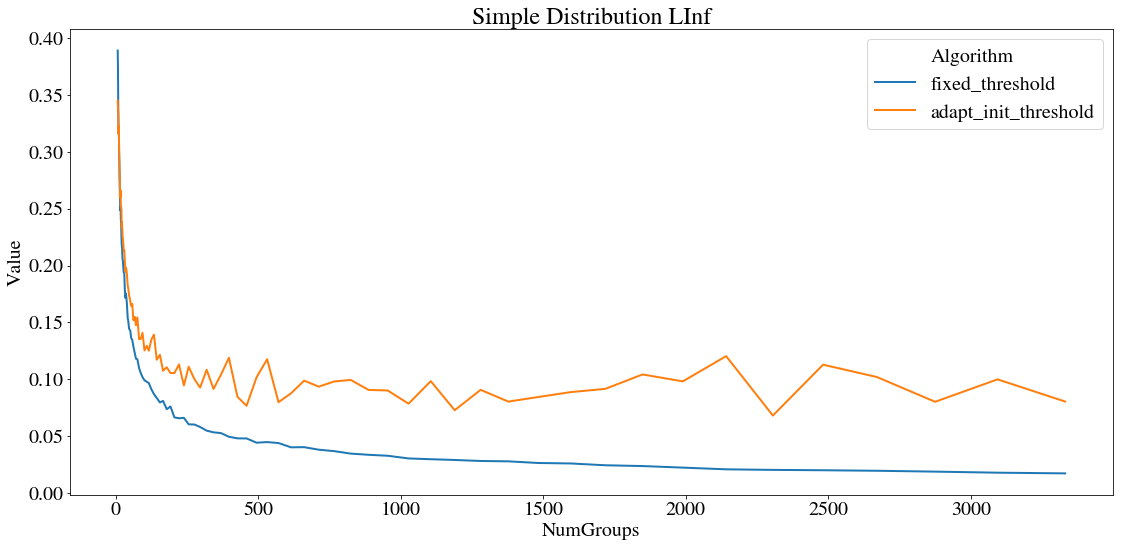

/home/sean/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


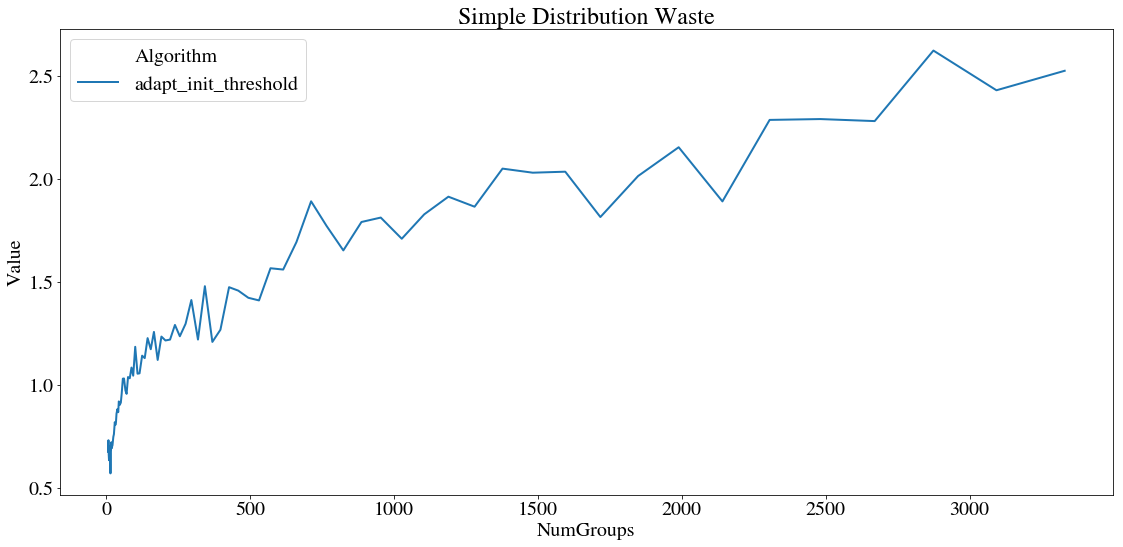

In [117]:
df = pd.DataFrame.from_records(data)
df.columns


plt.style.use('PaperDoubleFig.mplstyle.txt')
# Make some style choices for plotting 
colorWheel =['#2bd1e5',
            '#281bf5',
             '#db1bf5',
             '#F5CD1B',
            '#FF5733','#9cf51b',]
dashesStyles = [[3,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1],[1000,1],[8,2]]


#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
#plt.figure(figsize=(20,10))
#plt.title('Simple Distribution L1')
#sns.lineplot(x='NumGroups', y='value', hue='variable', data=df[df.Norm == 'L1'])

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]

plt.figure(figsize=(16,8))
# plt.rc('text', usetex=True)
plt.title('Simple Distribution LInf')
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', dashes = dash_styles, data=df[df.Norm == 'Linf'], ci = None)


plt.figure(figsize=(16,8))
# plt.rc('text', usetex=True)
plt.title('Simple Distribution Waste')
data_alg = df[df.Algorithm != 'fixed_threshold']
# data_alg = df
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', dashes = dash_styles, data=data_alg[data_alg.Norm == 'Waste'], ci=None)


/home/sean/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


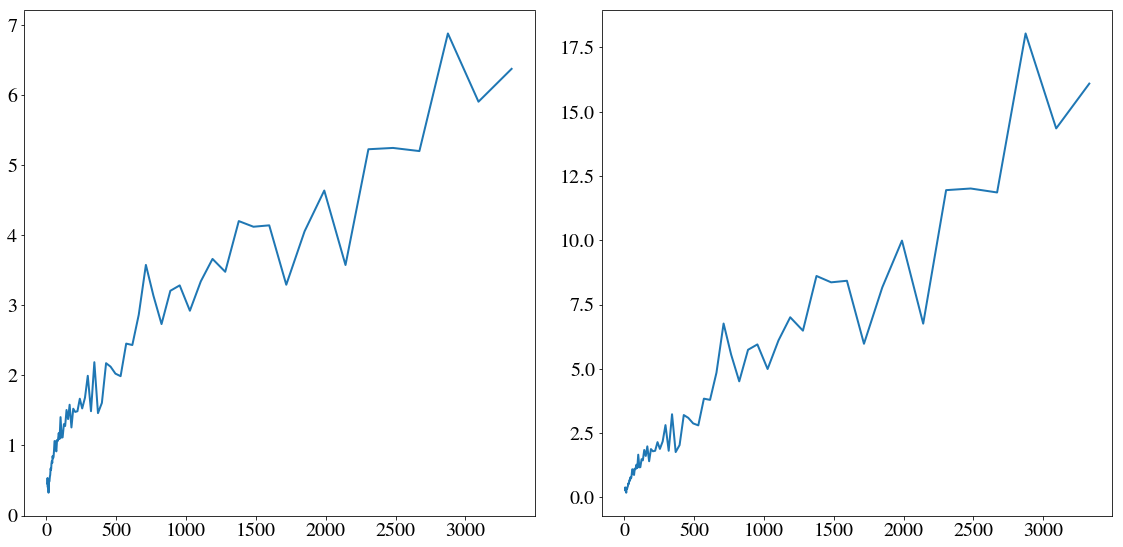

In [118]:
df_test = df[df.Norm == 'Waste']
df_test = df_test[df_test.Algorithm=='adapt_init_threshold']
df_test_2 = df_test.groupby(['NumGroups']).mean()
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(df_test_2**2)

plt.subplot(1,2,2)
plt.plot(df_test_2**3)



/home/sean/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


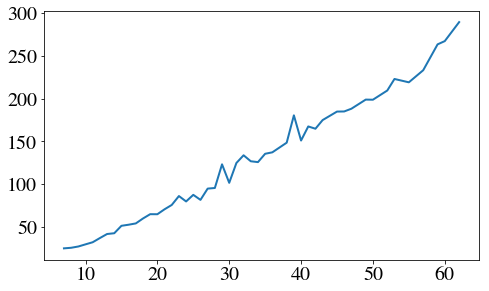

In [107]:

df_test = df[df.Norm == 'Linf']
df_test = df_test[df_test.Algorithm=='adapt_init_threshold']
df_test_2 = df_test.groupby(['NumGroups']).mean()
plt.plot(1 / (df_test_2**3))


### Group by Group Difference

In [30]:
fair_data = []

n = 100
num_iterations = 100

mean_size = 1.5
expected_size = np.zeros(n) + mean_size

for i in tqdm(range(num_iterations)):
    
    expected_size = np.zeros(n) + mean_size
    budget = n
    size = np.random.choice(size=n, a=[1.,2.], p=[1/2, 1/2])
    
    opt = offline_opt(budget, size, expected_size)
    for algo in algo_list:
        sol = algo(budget, size, expected_size)
        
        
        
        
        for j in range(n):
            data.append({'Location':j, 'Algorithm':algo.__name__, 'Value': opt[j] - sol[j]})
            
            
        fair_data.append({'Iteration':i, 'Algorithm':algo.__name__, 'Waste':(budget - np.sum(sol))/n, 'Envy':np.max(sol) - np.min(sol), 'Proportional':budget / np.sum(size) - np.min(sol)})
            
    for i in range(n):
        data.append({'Location': i, 'Algorithm':'Zero', 'Value': 0})

  0%|          | 0/100 [00:00<?, ?it/s]

[]

/home/sean/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


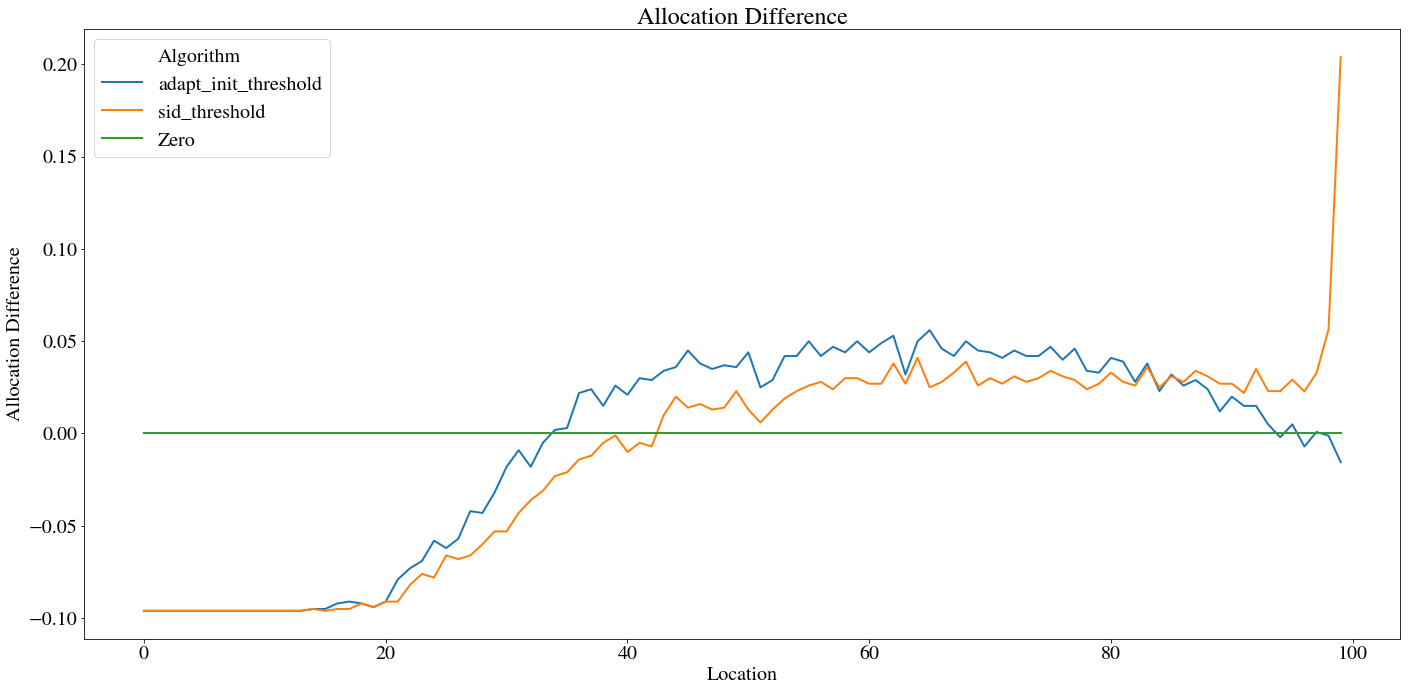

In [31]:
df = pd.DataFrame.from_records(data)

plt.figure(figsize=(20,10))
sns.lineplot(x='Location', y='Value', hue = 'Algorithm', data=df, ci = None)
plt.title('Allocation Difference')
plt.xlabel('Location')
plt.ylabel('Allocation Difference')
plt.plot()

Note: Discrepancy is between where max and average are between this plot and the other one.

### Printing Fairness Metrics

In [26]:
fair_df = pd.DataFrame.from_records(fair_data)
fair_df = fair_df.groupby(['Algorithm']).mean()
print(fair_df.drop(['Iteration'], axis=1))

                         Waste      Envy  Proportional
Algorithm                                             
adapt_init_threshold  0.323525  0.205645      0.110282
sid_threshold         0.316649  0.347123      0.251761
